In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

from utils.data import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

%load_ext autoreload
%autoreload 2

# DATA

In [2]:
TRAIN_FLAG = True
#DATA_SET = 'Shapes'
DATA_SET = 'Circles'
#DATA_SET = 'MNIST'

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=0.5)

[[  0 522]
 [  1 478]]
(1000, 1, 28, 28)
torch.Size([160, 1, 28, 28]) torch.Size([40, 1, 28, 28])
tensor(0.) tensor(1.)
CPU times: user 709 ms, sys: 178 ms, total: 887 ms
Wall time: 679 ms


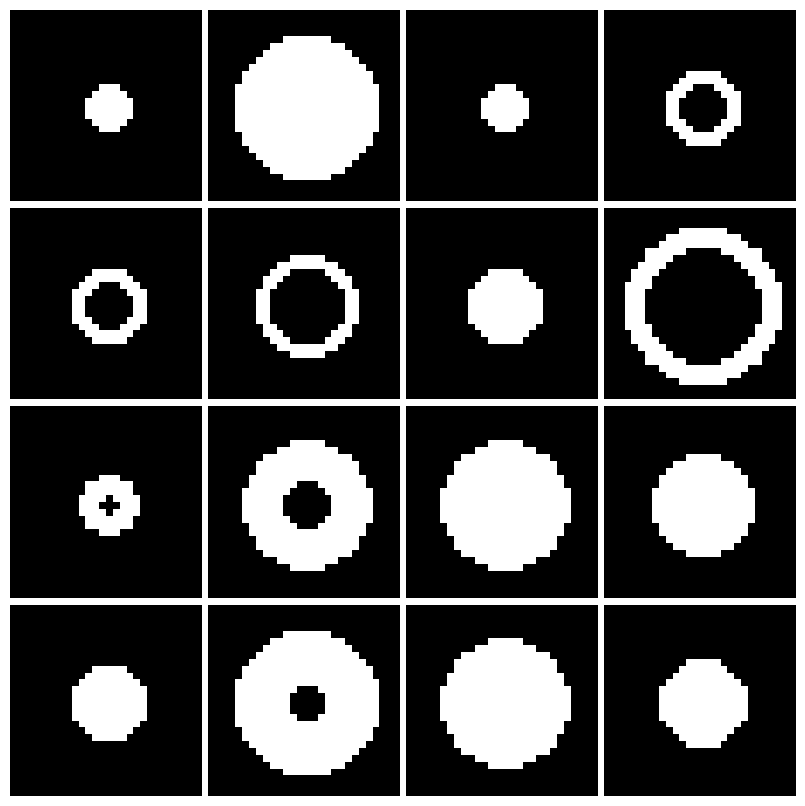

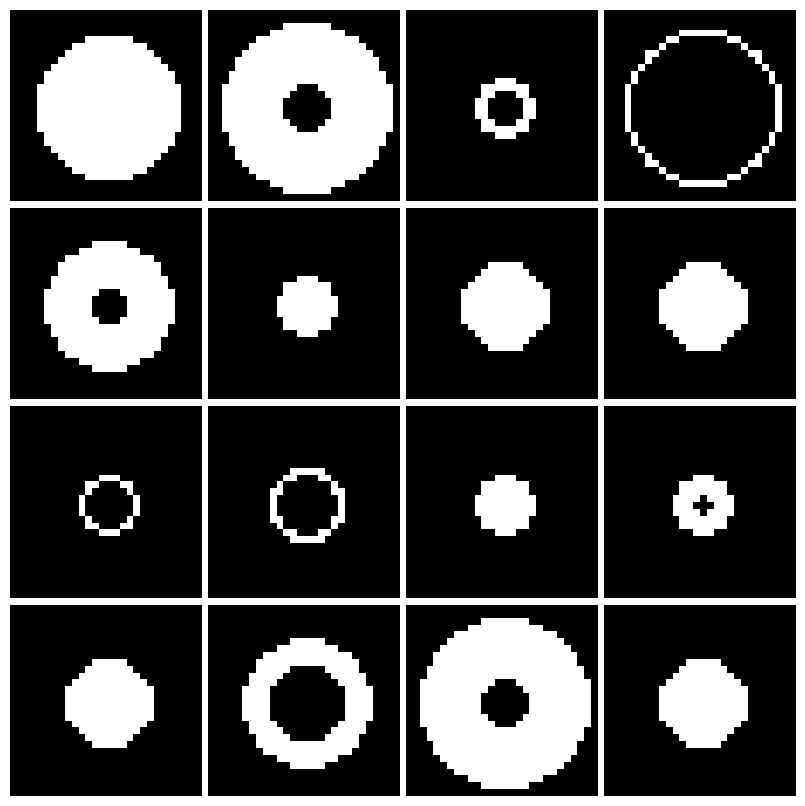

In [4]:
%%time

if DATA_SET == 'Circles' :
    shapes, targets = gen_circles_dataset(num_images=1000, seed=42)
    print(np.array(np.unique(targets, return_counts=True)).T)
    
    shapes = shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    subsampled_indeces = sample_indices(targets, k=100, max_classes=None, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    # train_indeces = sample_indices(targets, k=90, seed=42)
    # remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    # test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
    subsampled_indeces = sample_indices(targets, k=100, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    # train_indeces = sample_indices(mnist_trainset.targets, k=500, max_classes=2, seed=42)
    # remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    # test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=50, seed=42)

    subsampled_indeces = sample_indices(mnist_trainset.targets, k=1000, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))

    train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
    eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.

    train_labels = mnist_trainset.targets[train_indeces]
    eval_labels = mnist_trainset.targets[test_indeces]

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

plot_grid(train_dataset)
plot_grid(eval_dataset)

In [5]:
print(train_dataset.shape, train_dataset.min(), train_dataset.max(), train_dataset.mean(), train_dataset.std())
print(eval_dataset.shape, eval_dataset.min(), eval_dataset.max(), eval_dataset.mean(), eval_dataset.std())

torch.Size([160, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.2260) tensor(0.4182)
torch.Size([40, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.2477) tensor(0.4317)


In [6]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

# TRAIN

## Configure Training

In [7]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }

In [8]:
model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=2,
    reconstruction_loss="bce",
    n_lf=3,
    eps_lf=1e-3,
    beta_zero=0.3,
    temperature=0.8,
    regularization=1e-3
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['tiny']['encoder'](model_config),
    decoder=architecture_dict['tiny']['decoder'](model_config),
)

# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=2,
#     reconstruction_loss="bce",
# )

# model = VAE(
#     model_config=model_config,
#     encoder=architecture_dict['tiny']['encoder'](model_config),
#     decoder=architecture_dict['tiny']['decoder'](model_config),
# )

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 75 µs, sys: 25 µs, total: 100 µs
Wall time: 104 µs


946391

In [10]:
print(model)

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)


## Train

In [ ]:
%%time

from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=500,
    learning_rate=1e-3,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    #optimizer_cls="AdamW",
    #optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 10, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        #callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-06-05_14-55-38. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 160
 - per_device_eval_batch_size: 40
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fe4b83d40d0>

Successfully launched training !



Training of epoch 1/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 566.463
Eval loss: 528.5157
--------------------------------------------------------------------------


Training of epoch 2/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 530.2009
Eval loss: 506.6038
--------------------------------------------------------------------------


Training of epoch 3/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 501.1256
Eval loss: 481.366
--------------------------------------------------------------------------


Training of epoch 4/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 474.9424
Eval loss: 460.8887
--------------------------------------------------------------------------


Training of epoch 5/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 444.7349
Eval loss: 427.8191
--------------------------------------------------------------------------


Training of epoch 6/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 413.9421
Eval loss: 419.0107
--------------------------------------------------------------------------


Training of epoch 7/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 387.8498
Eval loss: 385.0627
--------------------------------------------------------------------------


Training of epoch 8/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 370.7706
Eval loss: 377.7671
--------------------------------------------------------------------------


Training of epoch 9/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 345.8225
Eval loss: 353.42
--------------------------------------------------------------------------


Training of epoch 10/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 337.7393
Eval loss: 354.3069
--------------------------------------------------------------------------


Training of epoch 11/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 316.4292
Eval loss: 333.6898
--------------------------------------------------------------------------


Training of epoch 12/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 311.7284
Eval loss: 313.6156
--------------------------------------------------------------------------


Training of epoch 13/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 292.1058
Eval loss: 286.7754
--------------------------------------------------------------------------


Training of epoch 14/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 284.1291
Eval loss: 290.0725
--------------------------------------------------------------------------


Training of epoch 15/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 269.6945
Eval loss: 263.2391
--------------------------------------------------------------------------


Training of epoch 16/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 255.2746
Eval loss: 254.562
--------------------------------------------------------------------------


Training of epoch 17/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 241.5331
Eval loss: 239.6566
--------------------------------------------------------------------------


Training of epoch 18/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 239.5712
Eval loss: 230.1804
--------------------------------------------------------------------------


Training of epoch 19/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 228.7236
Eval loss: 224.4325
--------------------------------------------------------------------------


Training of epoch 20/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 209.3549
Eval loss: 204.7855
--------------------------------------------------------------------------


Training of epoch 21/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 202.2864
Eval loss: 192.0785
--------------------------------------------------------------------------


Training of epoch 22/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 198.1399
Eval loss: 189.9448
--------------------------------------------------------------------------


Training of epoch 23/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 188.5354
Eval loss: 178.2362
--------------------------------------------------------------------------


Training of epoch 24/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 185.1484
Eval loss: 174.5507
--------------------------------------------------------------------------


Training of epoch 25/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 176.1242
Eval loss: 173.4823
--------------------------------------------------------------------------


Training of epoch 26/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.4199
Eval loss: 172.862
--------------------------------------------------------------------------


Training of epoch 27/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.8135
Eval loss: 177.2626
--------------------------------------------------------------------------


Training of epoch 28/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 164.6396
Eval loss: 161.2602
--------------------------------------------------------------------------


Training of epoch 29/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 155.8306
Eval loss: 158.3995
--------------------------------------------------------------------------


Training of epoch 30/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 150.2068
Eval loss: 150.4632
--------------------------------------------------------------------------


Training of epoch 31/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 145.7941
Eval loss: 147.715
--------------------------------------------------------------------------


Training of epoch 32/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 140.9939
Eval loss: 144.0631
--------------------------------------------------------------------------


Training of epoch 33/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 136.2099
Eval loss: 148.167
--------------------------------------------------------------------------


Training of epoch 34/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 131.1235
Eval loss: 145.5065
--------------------------------------------------------------------------


Training of epoch 35/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.6465
Eval loss: 133.2667
--------------------------------------------------------------------------


Training of epoch 36/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.7822
Eval loss: 134.0208
--------------------------------------------------------------------------


Training of epoch 37/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 118.1034
Eval loss: 137.8196
--------------------------------------------------------------------------


Training of epoch 38/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 113.7554
Eval loss: 129.4521
--------------------------------------------------------------------------


Training of epoch 39/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 114.0155
Eval loss: 119.6527
--------------------------------------------------------------------------


Training of epoch 40/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 109.9814
Eval loss: 123.6488
--------------------------------------------------------------------------


Training of epoch 41/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 106.3994
Eval loss: 118.3408
--------------------------------------------------------------------------


Training of epoch 42/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 103.6308
Eval loss: 120.3328
--------------------------------------------------------------------------


Training of epoch 43/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 99.8025
Eval loss: 116.5509
--------------------------------------------------------------------------


Training of epoch 44/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 99.4006
Eval loss: 111.385
--------------------------------------------------------------------------


Training of epoch 45/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 95.9076
Eval loss: 112.5359
--------------------------------------------------------------------------


Training of epoch 46/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 94.7574
Eval loss: 108.5522
--------------------------------------------------------------------------


Training of epoch 47/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 92.7934
Eval loss: 107.6002
--------------------------------------------------------------------------


Training of epoch 48/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 90.962
Eval loss: 106.6737
--------------------------------------------------------------------------


Training of epoch 49/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.7339
Eval loss: 106.1036
--------------------------------------------------------------------------


Training of epoch 50/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.0255
Eval loss: 98.834
--------------------------------------------------------------------------


Training of epoch 51/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 51/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 86.7645
Eval loss: 103.6849
--------------------------------------------------------------------------


Training of epoch 52/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 52/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 86.0861
Eval loss: 106.0726
--------------------------------------------------------------------------


Training of epoch 53/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 53/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.0008
Eval loss: 93.4739
--------------------------------------------------------------------------


Training of epoch 54/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 54/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.5617
Eval loss: 94.7623
--------------------------------------------------------------------------


Training of epoch 55/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 55/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.4987
Eval loss: 100.2483
--------------------------------------------------------------------------


Training of epoch 56/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 56/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 80.1761
Eval loss: 95.4599
--------------------------------------------------------------------------


Training of epoch 57/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 57/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.4155
Eval loss: 90.9729
--------------------------------------------------------------------------


Training of epoch 58/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 58/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.9305
Eval loss: 90.9804
--------------------------------------------------------------------------


Training of epoch 59/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 59/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 77.6716
Eval loss: 87.1026
--------------------------------------------------------------------------


Training of epoch 60/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 60/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.782
Eval loss: 88.4231
--------------------------------------------------------------------------


Training of epoch 61/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 61/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.0713
Eval loss: 90.3378
--------------------------------------------------------------------------


Training of epoch 62/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 62/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 75.294
Eval loss: 82.5615
--------------------------------------------------------------------------


Training of epoch 63/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 63/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 74.2032
Eval loss: 84.6721
--------------------------------------------------------------------------


Training of epoch 64/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 64/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 74.8117
Eval loss: 94.7027
--------------------------------------------------------------------------


Training of epoch 65/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 65/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 74.344
Eval loss: 81.1509
--------------------------------------------------------------------------


Training of epoch 66/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 66/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 71.4731
Eval loss: 78.8427
--------------------------------------------------------------------------


Training of epoch 67/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 67/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 72.1771
Eval loss: 80.8586
--------------------------------------------------------------------------


Training of epoch 68/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 68/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.8467
Eval loss: 81.119
--------------------------------------------------------------------------


Training of epoch 69/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 69/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.0782
Eval loss: 82.1083
--------------------------------------------------------------------------


Training of epoch 70/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 70/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.5056
Eval loss: 77.4568
--------------------------------------------------------------------------


Training of epoch 71/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 71/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.0643
Eval loss: 76.3543
--------------------------------------------------------------------------


Training of epoch 72/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 72/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.108
Eval loss: 78.1779
--------------------------------------------------------------------------


Training of epoch 73/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 73/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 68.0331
Eval loss: 83.1883
--------------------------------------------------------------------------


Training of epoch 74/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 74/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.7151
Eval loss: 77.4206
--------------------------------------------------------------------------


Training of epoch 75/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 75/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.5948
Eval loss: 76.5524
--------------------------------------------------------------------------


Training of epoch 76/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 76/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.6391
Eval loss: 81.8557
--------------------------------------------------------------------------


Training of epoch 77/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 77/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.2734
Eval loss: 79.667
--------------------------------------------------------------------------


Training of epoch 78/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 78/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.2731
Eval loss: 73.1005
--------------------------------------------------------------------------


Training of epoch 79/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 79/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.6835
Eval loss: 86.4841
--------------------------------------------------------------------------


Training of epoch 80/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 80/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.8635
Eval loss: 76.37
--------------------------------------------------------------------------


Training of epoch 81/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 81/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.9571
Eval loss: 69.8228
--------------------------------------------------------------------------


Training of epoch 82/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 82/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.9806
Eval loss: 69.6277
--------------------------------------------------------------------------


Training of epoch 83/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 83/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.0777
Eval loss: 70.0269
--------------------------------------------------------------------------


Training of epoch 84/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 84/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.2295
Eval loss: 70.225
--------------------------------------------------------------------------


Training of epoch 85/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 85/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.8356
Eval loss: 72.4553
--------------------------------------------------------------------------


Training of epoch 86/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 86/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.1089
Eval loss: 73.7684
--------------------------------------------------------------------------


Training of epoch 87/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 87/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.6813
Eval loss: 70.8702
--------------------------------------------------------------------------


Training of epoch 88/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 88/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.4566
Eval loss: 71.0471
--------------------------------------------------------------------------


Training of epoch 89/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 89/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.762
Eval loss: 66.9657
--------------------------------------------------------------------------


Training of epoch 90/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 90/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.862
Eval loss: 67.7369
--------------------------------------------------------------------------


Training of epoch 91/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 91/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.496
Eval loss: 67.0577
--------------------------------------------------------------------------


Training of epoch 92/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 92/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 57.5783
Eval loss: 67.8291
--------------------------------------------------------------------------


Training of epoch 93/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 93/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.4681
Eval loss: 67.3174
--------------------------------------------------------------------------


Training of epoch 94/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 94/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.0075
Eval loss: 68.7124
--------------------------------------------------------------------------


Training of epoch 95/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 95/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.5839
Eval loss: 72.0437
--------------------------------------------------------------------------


Training of epoch 96/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 96/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.445
Eval loss: 75.0712
--------------------------------------------------------------------------


Training of epoch 97/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 97/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.675
Eval loss: 68.5989
--------------------------------------------------------------------------


Training of epoch 98/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 98/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.0194
Eval loss: 65.0603
--------------------------------------------------------------------------


Training of epoch 99/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 99/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.6014
Eval loss: 64.7607
--------------------------------------------------------------------------


Training of epoch 100/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 100/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.0199
Eval loss: 64.8255
--------------------------------------------------------------------------


Training of epoch 101/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 101/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.1938
Eval loss: 66.033
--------------------------------------------------------------------------


Training of epoch 102/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 102/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.7556
Eval loss: 69.3965
--------------------------------------------------------------------------


Training of epoch 103/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 103/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.2637
Eval loss: 64.377
--------------------------------------------------------------------------


Training of epoch 104/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 104/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 52.9127
Eval loss: 68.5943
--------------------------------------------------------------------------


Training of epoch 105/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 105/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.4509
Eval loss: 59.2887
--------------------------------------------------------------------------


Training of epoch 106/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 106/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 52.5069
Eval loss: 63.1332
--------------------------------------------------------------------------


Training of epoch 107/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 107/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.1303
Eval loss: 60.1576
--------------------------------------------------------------------------


Training of epoch 108/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 108/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 52.1924
Eval loss: 60.6609
--------------------------------------------------------------------------


Training of epoch 109/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 109/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.4035
Eval loss: 72.1403
--------------------------------------------------------------------------


Training of epoch 110/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 110/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.7827
Eval loss: 62.3193
--------------------------------------------------------------------------


Training of epoch 111/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 111/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.9948
Eval loss: 59.4838
--------------------------------------------------------------------------


Training of epoch 112/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 112/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.8735
Eval loss: 62.0166
--------------------------------------------------------------------------


Training of epoch 113/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 113/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.3507
Eval loss: 80.2008
--------------------------------------------------------------------------


Training of epoch 114/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 114/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 50.2073
Eval loss: 75.4879
--------------------------------------------------------------------------


Training of epoch 115/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 115/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.9736
Eval loss: 65.9088
--------------------------------------------------------------------------


Training of epoch 116/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 116/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.6703
Eval loss: 68.2444
--------------------------------------------------------------------------


Epoch 00116: reducing learning rate of group 0 to 5.0000e-04.


Training of epoch 117/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 117/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.0709
Eval loss: 74.8914
--------------------------------------------------------------------------


Training of epoch 118/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 118/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.4908
Eval loss: 62.6825
--------------------------------------------------------------------------


Training of epoch 119/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 119/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.6131
Eval loss: 63.221
--------------------------------------------------------------------------


Training of epoch 120/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 120/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.8705
Eval loss: 69.0106
--------------------------------------------------------------------------


Training of epoch 121/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 121/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.8342
Eval loss: 59.346
--------------------------------------------------------------------------


Training of epoch 122/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 122/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.0197
Eval loss: 63.3242
--------------------------------------------------------------------------


Training of epoch 123/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 123/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.2964
Eval loss: 56.838
--------------------------------------------------------------------------


Training of epoch 124/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 124/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.8097
Eval loss: 60.7433
--------------------------------------------------------------------------


Training of epoch 125/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 125/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.8956
Eval loss: 64.7148
--------------------------------------------------------------------------


Training of epoch 126/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 126/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.6066
Eval loss: 68.9041
--------------------------------------------------------------------------


Training of epoch 127/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 127/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 48.2491
Eval loss: 57.5609
--------------------------------------------------------------------------


Training of epoch 128/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 128/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.2736
Eval loss: 61.4523
--------------------------------------------------------------------------


Training of epoch 129/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 129/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.5716
Eval loss: 57.6536
--------------------------------------------------------------------------


Training of epoch 130/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 130/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.494
Eval loss: 62.6921
--------------------------------------------------------------------------


Training of epoch 131/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 131/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.9317
Eval loss: 66.2791
--------------------------------------------------------------------------


Training of epoch 132/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 132/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.1013
Eval loss: 57.2999
--------------------------------------------------------------------------


Training of epoch 133/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 133/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.8587
Eval loss: 58.4925
--------------------------------------------------------------------------


Training of epoch 134/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 134/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.2797
Eval loss: 68.3648
--------------------------------------------------------------------------


Epoch 00134: reducing learning rate of group 0 to 2.5000e-04.


Training of epoch 135/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 135/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.5994
Eval loss: 54.3316
--------------------------------------------------------------------------


Training of epoch 136/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 136/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.67
Eval loss: 68.4156
--------------------------------------------------------------------------


Training of epoch 137/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 137/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.5901
Eval loss: 54.7685
--------------------------------------------------------------------------


Training of epoch 138/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 138/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.0756
Eval loss: 61.9796
--------------------------------------------------------------------------


Training of epoch 139/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 139/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.3059
Eval loss: 66.2629
--------------------------------------------------------------------------


Training of epoch 140/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 140/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.2299
Eval loss: 54.7685
--------------------------------------------------------------------------


Training of epoch 141/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 141/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.884
Eval loss: 59.534
--------------------------------------------------------------------------


Training of epoch 142/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 142/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.696
Eval loss: 57.9493
--------------------------------------------------------------------------


Training of epoch 143/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 143/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.467
Eval loss: 58.3072
--------------------------------------------------------------------------


Training of epoch 144/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 144/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.9602
Eval loss: 71.7678
--------------------------------------------------------------------------


Training of epoch 145/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 145/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.1609
Eval loss: 55.8922
--------------------------------------------------------------------------


Training of epoch 146/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 146/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.9085
Eval loss: 60.9605
--------------------------------------------------------------------------


Epoch 00146: reducing learning rate of group 0 to 1.2500e-04.


Training of epoch 147/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 147/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.3486
Eval loss: 56.9086
--------------------------------------------------------------------------


Training of epoch 148/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 148/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.2587
Eval loss: 70.5268
--------------------------------------------------------------------------


Training of epoch 149/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 149/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.9711
Eval loss: 54.6354
--------------------------------------------------------------------------


Training of epoch 150/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 150/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.7569
Eval loss: 58.978
--------------------------------------------------------------------------


Training of epoch 151/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 151/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.6124
Eval loss: 63.7719
--------------------------------------------------------------------------


Training of epoch 152/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 152/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.1429
Eval loss: 65.157
--------------------------------------------------------------------------


Training of epoch 153/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 153/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.8085
Eval loss: 58.2117
--------------------------------------------------------------------------


Training of epoch 154/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 154/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.7666
Eval loss: 56.9938
--------------------------------------------------------------------------


Training of epoch 155/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 155/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.7363
Eval loss: 68.3004
--------------------------------------------------------------------------


Training of epoch 156/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 156/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.923
Eval loss: 64.3793
--------------------------------------------------------------------------


Training of epoch 157/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 157/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.3719
Eval loss: 53.8548
--------------------------------------------------------------------------


Training of epoch 158/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 158/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.0698
Eval loss: 57.6824
--------------------------------------------------------------------------


Training of epoch 159/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 159/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.4803
Eval loss: 71.5027
--------------------------------------------------------------------------


Training of epoch 160/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 160/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.1269
Eval loss: 55.4401
--------------------------------------------------------------------------


Training of epoch 161/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 161/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.9208
Eval loss: 56.7764
--------------------------------------------------------------------------


Training of epoch 162/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 162/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.845
Eval loss: 66.0728
--------------------------------------------------------------------------


Training of epoch 163/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 163/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.4915
Eval loss: 64.6015
--------------------------------------------------------------------------


Training of epoch 164/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 164/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.118
Eval loss: 57.8228
--------------------------------------------------------------------------


Training of epoch 165/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 165/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.5395
Eval loss: 57.3142
--------------------------------------------------------------------------


Training of epoch 166/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 166/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6514
Eval loss: 54.7549
--------------------------------------------------------------------------


Training of epoch 167/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 167/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.1595
Eval loss: 53.587
--------------------------------------------------------------------------


Training of epoch 168/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 168/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8857
Eval loss: 54.8568
--------------------------------------------------------------------------


Training of epoch 169/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 169/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.9679
Eval loss: 69.9008
--------------------------------------------------------------------------


Training of epoch 170/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 170/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.0995
Eval loss: 53.9197
--------------------------------------------------------------------------


Training of epoch 171/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 171/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8132
Eval loss: 65.9694
--------------------------------------------------------------------------


Training of epoch 172/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 172/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.1082
Eval loss: 60.0015
--------------------------------------------------------------------------


Training of epoch 173/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 173/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.3113
Eval loss: 56.6578
--------------------------------------------------------------------------


Training of epoch 174/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 174/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6528
Eval loss: 56.6629
--------------------------------------------------------------------------


Training of epoch 175/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 175/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.9639
Eval loss: 58.9173
--------------------------------------------------------------------------


Training of epoch 176/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 176/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.738
Eval loss: 70.4537
--------------------------------------------------------------------------


Training of epoch 177/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 177/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2708
Eval loss: 53.8222
--------------------------------------------------------------------------


Training of epoch 178/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 178/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.3415
Eval loss: 63.0483
--------------------------------------------------------------------------


Epoch 00178: reducing learning rate of group 0 to 6.2500e-05.


Training of epoch 179/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 179/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8788
Eval loss: 63.3011
--------------------------------------------------------------------------


Training of epoch 180/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 180/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7009
Eval loss: 60.4985
--------------------------------------------------------------------------


Training of epoch 181/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 181/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8447
Eval loss: 55.4788
--------------------------------------------------------------------------


Training of epoch 182/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 182/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6308
Eval loss: 58.4269
--------------------------------------------------------------------------


Training of epoch 183/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 183/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6468
Eval loss: 68.4702
--------------------------------------------------------------------------


Training of epoch 184/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 184/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7579
Eval loss: 63.0161
--------------------------------------------------------------------------


Training of epoch 185/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 185/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.7122
Eval loss: 62.8782
--------------------------------------------------------------------------


Training of epoch 186/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 186/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3206
Eval loss: 55.7175
--------------------------------------------------------------------------


Training of epoch 187/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 187/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.71
Eval loss: 62.1506
--------------------------------------------------------------------------


Training of epoch 188/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 188/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.0558
Eval loss: 63.1403
--------------------------------------------------------------------------


Training of epoch 189/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 189/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6368
Eval loss: 63.5581
--------------------------------------------------------------------------


Epoch 00189: reducing learning rate of group 0 to 3.1250e-05.


Training of epoch 190/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 190/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.0547
Eval loss: 52.5254
--------------------------------------------------------------------------


Training of epoch 191/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 191/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1845
Eval loss: 57.716
--------------------------------------------------------------------------


Training of epoch 192/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 192/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8678
Eval loss: 64.5457
--------------------------------------------------------------------------


Training of epoch 193/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 193/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3724
Eval loss: 56.1683
--------------------------------------------------------------------------


Training of epoch 194/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 194/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6375
Eval loss: 54.3568
--------------------------------------------------------------------------


Training of epoch 195/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 195/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7861
Eval loss: 58.4328
--------------------------------------------------------------------------


Training of epoch 196/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 196/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2779
Eval loss: 57.6256
--------------------------------------------------------------------------


Training of epoch 197/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 197/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.1238
Eval loss: 56.2685
--------------------------------------------------------------------------


Training of epoch 198/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 198/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3861
Eval loss: 66.3426
--------------------------------------------------------------------------


Training of epoch 199/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 199/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.0537
Eval loss: 54.9784
--------------------------------------------------------------------------


Training of epoch 200/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 200/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6116
Eval loss: 56.9328
--------------------------------------------------------------------------


Training of epoch 201/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 201/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8626
Eval loss: 54.992
--------------------------------------------------------------------------


Epoch 00201: reducing learning rate of group 0 to 1.5625e-05.


Training of epoch 202/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 202/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4619
Eval loss: 53.9371
--------------------------------------------------------------------------


Training of epoch 203/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 203/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1643
Eval loss: 60.2787
--------------------------------------------------------------------------


Training of epoch 204/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 204/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4044
Eval loss: 59.0402
--------------------------------------------------------------------------


Training of epoch 205/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 205/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2179
Eval loss: 58.9563
--------------------------------------------------------------------------


Training of epoch 206/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 206/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4785
Eval loss: 71.8554
--------------------------------------------------------------------------


Training of epoch 207/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 207/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.148
Eval loss: 70.0182
--------------------------------------------------------------------------


Training of epoch 208/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 208/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.35
Eval loss: 54.959
--------------------------------------------------------------------------


Training of epoch 209/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 209/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7549
Eval loss: 56.2573
--------------------------------------------------------------------------


Training of epoch 210/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 210/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1689
Eval loss: 63.0263
--------------------------------------------------------------------------


Training of epoch 211/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 211/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7446
Eval loss: 51.7073
--------------------------------------------------------------------------


Training of epoch 212/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 212/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0603
Eval loss: 67.1979
--------------------------------------------------------------------------


Training of epoch 213/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 213/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9305
Eval loss: 58.4195
--------------------------------------------------------------------------


Training of epoch 214/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 214/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.138
Eval loss: 58.9509
--------------------------------------------------------------------------


Training of epoch 215/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 215/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.0607
Eval loss: 57.7784
--------------------------------------------------------------------------


Training of epoch 216/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 216/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4568
Eval loss: 51.878
--------------------------------------------------------------------------


Training of epoch 217/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 217/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0691
Eval loss: 53.4532
--------------------------------------------------------------------------


Training of epoch 218/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 218/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6117
Eval loss: 60.4497
--------------------------------------------------------------------------


Training of epoch 219/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 219/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4809
Eval loss: 59.7632
--------------------------------------------------------------------------


Training of epoch 220/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 220/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9197
Eval loss: 52.7427
--------------------------------------------------------------------------


Training of epoch 221/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 221/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2416
Eval loss: 57.7277
--------------------------------------------------------------------------


Training of epoch 222/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 222/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9989
Eval loss: 54.2517
--------------------------------------------------------------------------


Epoch 00222: reducing learning rate of group 0 to 7.8125e-06.


Training of epoch 223/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 223/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9779
Eval loss: 63.3684
--------------------------------------------------------------------------


Training of epoch 224/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 224/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3441
Eval loss: 53.8877
--------------------------------------------------------------------------


Training of epoch 225/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 225/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6165
Eval loss: 59.9566
--------------------------------------------------------------------------


Training of epoch 226/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 226/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5334
Eval loss: 62.5925
--------------------------------------------------------------------------


Training of epoch 227/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 227/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2733
Eval loss: 59.5003
--------------------------------------------------------------------------


Training of epoch 228/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 228/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.071
Eval loss: 55.6772
--------------------------------------------------------------------------


Training of epoch 229/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 229/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9862
Eval loss: 57.5125
--------------------------------------------------------------------------


Training of epoch 230/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 230/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.809
Eval loss: 53.3241
--------------------------------------------------------------------------


Training of epoch 231/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 231/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4523
Eval loss: 58.7485
--------------------------------------------------------------------------


Training of epoch 232/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 232/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2231
Eval loss: 63.6788
--------------------------------------------------------------------------


Training of epoch 233/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 233/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3829
Eval loss: 59.2036
--------------------------------------------------------------------------


Epoch 00233: reducing learning rate of group 0 to 3.9063e-06.


Training of epoch 234/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 234/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4528
Eval loss: 58.3605
--------------------------------------------------------------------------


Training of epoch 235/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 235/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1503
Eval loss: 53.2829
--------------------------------------------------------------------------


Training of epoch 236/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 236/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.773
Eval loss: 57.0695
--------------------------------------------------------------------------


Training of epoch 237/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 237/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6675
Eval loss: 52.9723
--------------------------------------------------------------------------


Training of epoch 238/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 238/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5044
Eval loss: 52.7292
--------------------------------------------------------------------------


Training of epoch 239/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 239/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1575
Eval loss: 57.4414
--------------------------------------------------------------------------


Training of epoch 240/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 240/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.291
Eval loss: 52.7712
--------------------------------------------------------------------------


Training of epoch 241/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 241/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.713
Eval loss: 55.7261
--------------------------------------------------------------------------


Training of epoch 242/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 242/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.9929
Eval loss: 54.7227
--------------------------------------------------------------------------


Training of epoch 243/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 243/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2222
Eval loss: 73.9318
--------------------------------------------------------------------------


Training of epoch 244/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 244/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5698
Eval loss: 54.5273
--------------------------------------------------------------------------


Epoch 00244: reducing learning rate of group 0 to 1.9531e-06.


Training of epoch 245/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 245/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3671
Eval loss: 56.5856
--------------------------------------------------------------------------


Training of epoch 246/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 246/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.9045
Eval loss: 64.3981
--------------------------------------------------------------------------


Training of epoch 247/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 247/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7906
Eval loss: 57.7074
--------------------------------------------------------------------------


Training of epoch 248/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 248/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6379
Eval loss: 53.0402
--------------------------------------------------------------------------


Training of epoch 249/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 249/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0436
Eval loss: 60.6392
--------------------------------------------------------------------------


Training of epoch 250/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 250/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0761
Eval loss: 51.8041
--------------------------------------------------------------------------


Training of epoch 251/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 251/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8658
Eval loss: 54.7581
--------------------------------------------------------------------------


Training of epoch 252/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 252/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1758
Eval loss: 71.0944
--------------------------------------------------------------------------


Training of epoch 253/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 253/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5397
Eval loss: 64.5384
--------------------------------------------------------------------------


Training of epoch 254/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 254/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3393
Eval loss: 56.6274
--------------------------------------------------------------------------


Training of epoch 255/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 255/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.05
Eval loss: 63.6646
--------------------------------------------------------------------------


Epoch 00255: reducing learning rate of group 0 to 9.7656e-07.


Training of epoch 256/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 256/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4982
Eval loss: 64.1799
--------------------------------------------------------------------------


Training of epoch 257/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 257/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.5404
Eval loss: 73.7139
--------------------------------------------------------------------------


Training of epoch 258/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 258/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3927
Eval loss: 61.6428
--------------------------------------------------------------------------


Training of epoch 259/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 259/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5868
Eval loss: 58.92
--------------------------------------------------------------------------


Training of epoch 260/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 260/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3305
Eval loss: 59.8988
--------------------------------------------------------------------------


Training of epoch 261/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 261/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4641
Eval loss: 53.0943
--------------------------------------------------------------------------


Training of epoch 262/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 262/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.0044
Eval loss: 60.6222
--------------------------------------------------------------------------


Training of epoch 263/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 263/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.476
Eval loss: 55.3312
--------------------------------------------------------------------------


Training of epoch 264/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 264/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2999
Eval loss: 66.6271
--------------------------------------------------------------------------


Training of epoch 265/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 265/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4945
Eval loss: 57.5065
--------------------------------------------------------------------------


Training of epoch 266/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 266/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4649
Eval loss: 56.9078
--------------------------------------------------------------------------


Epoch 00266: reducing learning rate of group 0 to 4.8828e-07.


Training of epoch 267/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 267/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0163
Eval loss: 58.5513
--------------------------------------------------------------------------


Training of epoch 268/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 268/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3515
Eval loss: 74.049
--------------------------------------------------------------------------


Training of epoch 269/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 269/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.517
Eval loss: 66.891
--------------------------------------------------------------------------


Training of epoch 270/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 270/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9915
Eval loss: 68.2961
--------------------------------------------------------------------------


Training of epoch 271/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 271/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3792
Eval loss: 53.1528
--------------------------------------------------------------------------


Training of epoch 272/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 272/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3984
Eval loss: 61.4323
--------------------------------------------------------------------------


Training of epoch 273/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 273/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.9105
Eval loss: 54.9059
--------------------------------------------------------------------------


Training of epoch 274/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 274/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7246
Eval loss: 68.9683
--------------------------------------------------------------------------


Training of epoch 275/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 275/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3235
Eval loss: 59.1014
--------------------------------------------------------------------------


Training of epoch 276/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 276/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9369
Eval loss: 58.0521
--------------------------------------------------------------------------


Training of epoch 277/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 277/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6706
Eval loss: 58.8707
--------------------------------------------------------------------------


Epoch 00277: reducing learning rate of group 0 to 2.4414e-07.


Training of epoch 278/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 278/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3089
Eval loss: 60.1078
--------------------------------------------------------------------------


Training of epoch 279/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 279/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5246
Eval loss: 53.8477
--------------------------------------------------------------------------


Training of epoch 280/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 280/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0727
Eval loss: 61.4548
--------------------------------------------------------------------------


Training of epoch 281/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 281/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5291
Eval loss: 52.2771
--------------------------------------------------------------------------


Training of epoch 282/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 282/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2548
Eval loss: 56.0527
--------------------------------------------------------------------------


Training of epoch 283/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 283/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.306
Eval loss: 53.1686
--------------------------------------------------------------------------


Training of epoch 284/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 284/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2149
Eval loss: 55.8532
--------------------------------------------------------------------------


Training of epoch 285/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 285/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7787
Eval loss: 70.9045
--------------------------------------------------------------------------


Training of epoch 286/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 286/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5106
Eval loss: 53.7348
--------------------------------------------------------------------------


Training of epoch 287/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 287/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3967
Eval loss: 65.4063
--------------------------------------------------------------------------


Training of epoch 288/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 288/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4825
Eval loss: 69.0728
--------------------------------------------------------------------------


Epoch 00288: reducing learning rate of group 0 to 1.2207e-07.


Training of epoch 289/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 289/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.591
Eval loss: 56.7428
--------------------------------------------------------------------------


Training of epoch 290/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 290/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1207
Eval loss: 50.9904
--------------------------------------------------------------------------


Training of epoch 291/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 291/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5855
Eval loss: 67.8665
--------------------------------------------------------------------------


Training of epoch 292/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 292/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0438
Eval loss: 61.3803
--------------------------------------------------------------------------


Training of epoch 293/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 293/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8217
Eval loss: 60.2919
--------------------------------------------------------------------------


Training of epoch 294/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 294/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2897
Eval loss: 61.974
--------------------------------------------------------------------------


Training of epoch 295/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 295/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3112
Eval loss: 56.0585
--------------------------------------------------------------------------


Training of epoch 296/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 296/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0868
Eval loss: 61.19
--------------------------------------------------------------------------


Training of epoch 297/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 297/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9682
Eval loss: 57.4394
--------------------------------------------------------------------------


Training of epoch 298/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 298/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0758
Eval loss: 62.4547
--------------------------------------------------------------------------


Training of epoch 299/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 299/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3564
Eval loss: 55.3901
--------------------------------------------------------------------------


Training of epoch 300/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 300/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6706
Eval loss: 61.0314
--------------------------------------------------------------------------


Training of epoch 301/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 301/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9526
Eval loss: 53.4949
--------------------------------------------------------------------------


Epoch 00301: reducing learning rate of group 0 to 6.1035e-08.


Training of epoch 302/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 302/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1582
Eval loss: 58.2846
--------------------------------------------------------------------------


Training of epoch 303/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 303/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.963
Eval loss: 55.9441
--------------------------------------------------------------------------


Training of epoch 304/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 304/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3472
Eval loss: 53.2287
--------------------------------------------------------------------------


Training of epoch 305/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 305/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4982
Eval loss: 58.0336
--------------------------------------------------------------------------


Training of epoch 306/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 306/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4789
Eval loss: 52.2372
--------------------------------------------------------------------------


Training of epoch 307/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 307/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0614
Eval loss: 55.8517
--------------------------------------------------------------------------


Training of epoch 308/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 308/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4286
Eval loss: 65.9269
--------------------------------------------------------------------------


Training of epoch 309/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 309/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.9891
Eval loss: 65.4646
--------------------------------------------------------------------------


Training of epoch 310/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 310/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5251
Eval loss: 61.642
--------------------------------------------------------------------------


Training of epoch 311/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 311/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6442
Eval loss: 58.4855
--------------------------------------------------------------------------


Training of epoch 312/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 312/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2019
Eval loss: 53.5037
--------------------------------------------------------------------------


Epoch 00312: reducing learning rate of group 0 to 3.0518e-08.


Training of epoch 313/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 313/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4865
Eval loss: 64.051
--------------------------------------------------------------------------


Training of epoch 314/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 314/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.609
Eval loss: 56.9366
--------------------------------------------------------------------------


Training of epoch 315/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 315/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4007
Eval loss: 53.3951
--------------------------------------------------------------------------


Training of epoch 316/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 316/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1703
Eval loss: 62.9168
--------------------------------------------------------------------------


Training of epoch 317/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 317/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7091
Eval loss: 52.2368
--------------------------------------------------------------------------


Training of epoch 318/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 318/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.636
Eval loss: 69.1392
--------------------------------------------------------------------------


Training of epoch 319/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 319/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1412
Eval loss: 61.6788
--------------------------------------------------------------------------


Training of epoch 320/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 320/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5898
Eval loss: 70.189
--------------------------------------------------------------------------


Training of epoch 321/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 321/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.092
Eval loss: 58.6913
--------------------------------------------------------------------------


Training of epoch 322/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 322/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6068
Eval loss: 66.3958
--------------------------------------------------------------------------


Training of epoch 323/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 323/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0593
Eval loss: 62.8723
--------------------------------------------------------------------------


Epoch 00323: reducing learning rate of group 0 to 1.5259e-08.


Training of epoch 324/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 324/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4226
Eval loss: 56.8248
--------------------------------------------------------------------------


Training of epoch 325/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 325/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2094
Eval loss: 73.6284
--------------------------------------------------------------------------


Training of epoch 326/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 326/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8091
Eval loss: 59.3389
--------------------------------------------------------------------------


Training of epoch 327/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 327/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1109
Eval loss: 58.5396
--------------------------------------------------------------------------


Training of epoch 328/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 328/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1772
Eval loss: 62.4765
--------------------------------------------------------------------------


Training of epoch 329/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 329/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5799
Eval loss: 60.7062
--------------------------------------------------------------------------


Training of epoch 330/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 330/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.463
Eval loss: 66.5981
--------------------------------------------------------------------------


Training of epoch 331/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 331/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2814
Eval loss: 64.051
--------------------------------------------------------------------------


Training of epoch 332/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 332/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7086
Eval loss: 59.303
--------------------------------------------------------------------------


Training of epoch 333/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 333/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3458
Eval loss: 55.4478
--------------------------------------------------------------------------


Training of epoch 334/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 334/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1333
Eval loss: 56.0526
--------------------------------------------------------------------------


Training of epoch 335/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 335/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.71
Eval loss: 53.5436
--------------------------------------------------------------------------


Training of epoch 336/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 336/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3259
Eval loss: 85.5595
--------------------------------------------------------------------------


Training of epoch 337/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 337/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5344
Eval loss: 51.8482
--------------------------------------------------------------------------


Training of epoch 338/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 338/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1132
Eval loss: 65.8089
--------------------------------------------------------------------------


Training of epoch 339/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 339/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9295
Eval loss: 55.7915
--------------------------------------------------------------------------


Training of epoch 340/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 340/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.107
Eval loss: 55.0547
--------------------------------------------------------------------------


Training of epoch 341/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 341/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2756
Eval loss: 53.9054
--------------------------------------------------------------------------


Training of epoch 342/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 342/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.442
Eval loss: 57.4034
--------------------------------------------------------------------------


Training of epoch 343/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 343/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8043
Eval loss: 57.5283
--------------------------------------------------------------------------


Training of epoch 344/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 344/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1023
Eval loss: 58.0789
--------------------------------------------------------------------------


Training of epoch 345/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 345/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0504
Eval loss: 59.525
--------------------------------------------------------------------------


Training of epoch 346/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 346/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2018
Eval loss: 54.03
--------------------------------------------------------------------------


Training of epoch 347/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 347/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5628
Eval loss: 65.9651
--------------------------------------------------------------------------


Training of epoch 348/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 348/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4341
Eval loss: 64.5095
--------------------------------------------------------------------------


Training of epoch 349/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 349/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8654
Eval loss: 58.1964
--------------------------------------------------------------------------


Training of epoch 350/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 350/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3234
Eval loss: 55.917
--------------------------------------------------------------------------


Training of epoch 351/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 351/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.7723
Eval loss: 56.6669
--------------------------------------------------------------------------


Training of epoch 352/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 352/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.9145
Eval loss: 65.7781
--------------------------------------------------------------------------


Training of epoch 353/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 353/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.0787
Eval loss: 56.8074
--------------------------------------------------------------------------


Training of epoch 354/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 354/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1311
Eval loss: 55.4585
--------------------------------------------------------------------------


Training of epoch 355/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 355/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2488
Eval loss: 54.8235
--------------------------------------------------------------------------


Training of epoch 356/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 356/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.7946
Eval loss: 65.4555
--------------------------------------------------------------------------


Training of epoch 357/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 357/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2797
Eval loss: 52.414
--------------------------------------------------------------------------


Training of epoch 358/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 358/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3325
Eval loss: 56.6504
--------------------------------------------------------------------------


Training of epoch 359/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 359/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2658
Eval loss: 66.9803
--------------------------------------------------------------------------


Training of epoch 360/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 360/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.9656
Eval loss: 62.354
--------------------------------------------------------------------------


Training of epoch 361/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 361/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3924
Eval loss: 52.7594
--------------------------------------------------------------------------


Training of epoch 362/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 362/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2649
Eval loss: 63.5972
--------------------------------------------------------------------------


Training of epoch 363/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 363/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4094
Eval loss: 63.2706
--------------------------------------------------------------------------


Training of epoch 364/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 364/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3982
Eval loss: 54.9823
--------------------------------------------------------------------------


Training of epoch 365/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 365/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1535
Eval loss: 53.9771
--------------------------------------------------------------------------


Training of epoch 366/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 366/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5683
Eval loss: 53.8418
--------------------------------------------------------------------------


Training of epoch 367/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 367/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6246
Eval loss: 57.5894
--------------------------------------------------------------------------


Training of epoch 368/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 368/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1224
Eval loss: 70.7311
--------------------------------------------------------------------------


Training of epoch 369/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 369/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.1408
Eval loss: 59.8584
--------------------------------------------------------------------------


Training of epoch 370/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 370/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.3636
Eval loss: 53.1794
--------------------------------------------------------------------------


Training of epoch 371/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 371/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.5874
Eval loss: 60.6492
--------------------------------------------------------------------------


Training of epoch 372/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 372/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.8837
Eval loss: 62.2635
--------------------------------------------------------------------------


Training of epoch 373/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 373/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4653
Eval loss: 65.6386
--------------------------------------------------------------------------


Training of epoch 374/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 374/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.8494
Eval loss: 61.8162
--------------------------------------------------------------------------


Training of epoch 375/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 375/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4835
Eval loss: 59.4014
--------------------------------------------------------------------------


Training of epoch 376/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 376/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.0015
Eval loss: 73.2163
--------------------------------------------------------------------------


Training of epoch 377/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 377/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.2166
Eval loss: 55.9422
--------------------------------------------------------------------------


Training of epoch 378/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 378/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4159
Eval loss: 61.8273
--------------------------------------------------------------------------


Training of epoch 379/500:   0%|          | 0/1 [00:00<?, ?batch/s]

## Trained Model

In [ ]:
from pythae.models import AutoModel

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])
    #trained_model = AutoModel.load_from_hf_hub(hf_hub_path="clementchadebec/reproduced_vae", allow_pickle=True)

# LATENT SPACE

In [ ]:
# latents = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(latents[:, 0], latents[:, 1], c=eval_labels, cmap='viridis', marker='o')
# legend = plt.legend(*scatter.legend_elements(), title="Classes")


In [ ]:
# Extract latent space representations
z_mean = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()
z_log_var = trained_model.encoder(eval_dataset.to(device)).log_covariance.detach().cpu().numpy()
y_test = eval_labels

# Plotting the latent space
def plot_cov_ellipse(mean, cov, ax, color='gray', nstd=1.0, **kwargs):
    """Plots an ellipse representing the covariance matrix."""
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=color, edgecolor='none', **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * nstd
    scale_y = np.sqrt(cov[1, 1]) * nstd
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean[0], mean[1])
    
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot covariance ellipses
for i in range(len(z_mean)):
    cov = np.diag(np.exp(z_log_var[i]))
    plot_cov_ellipse(z_mean[i], cov, ax, color='gray', alpha=0.2)
    
scatter = ax.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', alpha=1)
legend = plt.legend(*scatter.legend_elements(), title="Classes")

plt.colorbar(scatter, ax=ax)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Latent Space of VAE with Covariance Ellipses')
plt.show()

# RECONSTRUCTIONS

In [ ]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

plot_grid(reconstructions)

# INTERPOLATIONS

In [ ]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

### Metrics

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# FID score computation class
fid_calculator = FrechetInceptionDistance(feature=64, reset_real_features=False, normalize=True)
fid_calculator.update(train_dataset.expand(train_dataset.shape[0], 3, 28, 28)[:200,].to('cpu'), real=True)

# IS score computation class
is_calculator = InceptionScore(normalize=True)

def compute_fid_score(gen_data):
    # Lower is better
    # greater sample variety
    fid_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu(), real=False)
    fid_score = fid_calculator.compute().item()
    print(f"FID = {fid_score:.4f}")
    return fid_score

def compute_is_score(gen_data):
    # Higher is better
    # better quality within individual images
    is_calculator.update(gen_data.expand(gen_data.shape[0], 3, 28, 28).cpu())
    is_score = is_calculator.compute()
    print(f"IS [mean] = {is_score[0].item():.4f}")
    print(f"IS [std] = {is_score[1].item():.4f}")


## Generators

### Normal Sampler

In [ ]:
from pythae.samplers import NormalSampler

sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

In [ ]:
plot_grid(gen_data.data.cpu())
compute_fid_score(gen_data)
compute_is_score(gen_data)

### Gaussian Mixture Model Sampler

In [ ]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=2
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

In [ ]:
plot_grid(gmm_gen_data.data.cpu())
compute_fid_score(gmm_gen_data)
compute_is_score(gmm_gen_data)

### RHVAE Sampler

In [ ]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig

rh_sampler_config = RHVAESamplerConfig(
    mcmc_steps_nbr = 100,
    n_lf = 10,
    eps_lf = 1e-3,
    beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

In [ ]:
plot_grid(rh_gen_data.cpu())
compute_fid_score(rh_gen_data)
compute_is_score(rh_gen_data)